In [2]:
import eddy_footprint as ef
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

from sublimpy import utils, extrautils

In [3]:
start_date = '20221101'
end_date = '20230619'
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"

In [4]:
tidy_df = pd.read_parquet(sos_tidy_fn)
# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

In [5]:
tidy_df = tidy_df[tidy_df.time.dt.month==12][tidy_df.time.dt.day > 0]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_40611/1993218479.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tidy_df = tidy_df[tidy_df.time.dt.month==12][tidy_df.time.dt.day > 0]


In [7]:
import swifter

In [8]:
tidy_df_streamwise = tidy_df.swifter.groupby('time').apply(extrautils.streamwise_coordinates_single_rotation_tidy_df)
tidy_df_streamwise = tidy_df_streamwise.reset_index(drop=True)

  0%|          | 0/22 [00:00<?, ?it/s]

2024-08-21 15:14:51,269	INFO worker.py:1781 -- Started a local Ray instance.


In [9]:
footprint_inputs_table = tidy_df[tidy_df.variable.isin([
    'P_10m_c',
    
    'T_3m_c', 'u*_3m_c', 'spd_3m_c', 'v_v_3m_c', 'dir_3m_c', 'L_3m_c', 'v_v__3m_c',
    'T_5m_c', 'u*_5m_c', 'spd_5m_c', 'v_v_5m_c', 'dir_5m_c', 'L_5m_c', 'v_v__5m_c',
    'T_10m_c', 'u*_10m_c', 'spd_10m_c', 'v_v_10m_c', 'dir_10m_c', 'L_10m_c', 'v_v__10m_c',
    'T_15m_c', 'u*_15m_c', 'spd_15m_c', 'v_v_15m_c', 'dir_15m_c', 'L_15m_c', 'v_v__15m_c',
    'T_20m_c', 'u*_20m_c', 'spd_20m_c', 'v_v_20m_c', 'dir_20m_c', 'L_20m_c', 'v_v__20m_c',

    'u*_3m_d', 'spd_3m_d', 'v_v_3m_d', 'dir_3m_d', 'L_3m_d', 'v_v__3m_d',
    'u*_3m_ue', 'spd_3m_ue', 'v_v_3m_ue', 'dir_3m_ue', 'L_3m_ue', 'v_v__3m_ue',
    'u*_3m_uw', 'spd_3m_uw', 'v_v_3m_uw', 'dir_3m_uw', 'L_3m_uw', 'v_v__3m_uw',

    'u*_10m_d', 'spd_10m_d', 'v_v_10m_d', 'dir_10m_d', 'L_10m_d', 'v_v__10m_d',
    'u*_10m_ue', 'spd_10m_ue', 'v_v_10m_ue', 'dir_10m_ue', 'L_10m_ue', 'v_v__10m_ue',
    'u*_10m_uw', 'spd_10m_uw', 'v_v_10m_uw', 'dir_10m_uw', 'L_10m_uw', 'v_v__10m_uw',
])].pivot_table(
    index='time', 
    columns='variable', 
    values = 'value'
)

footprint_inputs_table.head(3)

variable,L_10m_c,L_15m_c,L_20m_c,L_3m_c,L_5m_c,P_10m_c,T_10m_c,T_15m_c,T_20m_c,T_3m_c,...,v_v__10m_d,v_v__10m_ue,v_v__10m_uw,v_v__15m_c,v_v__20m_c,v_v__3m_c,v_v__3m_d,v_v__3m_ue,v_v__3m_uw,v_v__5m_c
time,,,,,,,,,,,,,,,,,,,,,
2022-12-01 00:00:00,3.125747,-2.317983,-1.413126,-1.308248,-1.747019,717.794617,-7.562340,-7.269151,-7.017433,-8.716485,...,0.956627,1.132794,1.283757,1.073431,0.812711,1.032369,0.958476,1.086812,1.047928,1.145760
2022-12-01 00:30:00,0.747547,0.912299,0.707481,0.337296,0.364399,717.740417,-6.671501,-6.263221,-5.994219,-7.878613,...,0.869471,0.794611,1.010384,0.958407,0.903045,0.890197,0.907870,0.884131,0.831525,0.876111
2022-12-01 01:00:00,-3.517745,2.269270,-4.592070,-11.661402,-3.900580,717.814758,-8.527075,-8.264359,-7.971638,-9.605273,...,0.761700,0.805880,0.858448,0.729715,0.582475,0.994828,0.984710,0.923340,0.971495,1.019459


# Using eddy_footprint library

In [10]:
locs = [
    '3m_d', '3m_ue', '3m_uw', 
    '10m_d', '10m_ue', '10m_uw', 
    '3m_c', '5m_c', '10m_c', '15m_c', '20m_c',
    
]
foots_ls = []
for loc in locs:
    [height, tower] = loc.split('m_')
    foots_ls.append(
        ef.calc_footprint(
            air_pressure =          footprint_inputs_table.reset_index().dropna()['P_10m_c']*100,
            air_temperature =       footprint_inputs_table.reset_index().dropna()[f'T_{height}m_c'] + 273, 
            friction_velocity   =   footprint_inputs_table.reset_index().dropna()[f'u*_{height}m_{tower}'],
            wind_speed  =           footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'],
            cross_wind_variance =   footprint_inputs_table.reset_index().dropna()[f'v_v__{height}m_{tower}'],
            wind_direction  =       footprint_inputs_table.reset_index().dropna()[f'dir_{height}m_{tower}'],
            monin_obukhov_length =  footprint_inputs_table.reset_index().dropna()[f'L_{height}m_c'],
            time    =               footprint_inputs_table.reset_index().dropna().time,
            instrument_height   =   3,
            roughness_length    =   0.0001,
            resolution  =           2,
            workers =               -1,
            # method  =               'Hsieh',
            method="Kormann & Meixner",
            domain_length = 250
        )
    )

In [11]:
new_foots_ls = []
for loc, foots in zip(locs,foots_ls):
    [height, tower] = loc.split('m_')
    foots = foots.expand_dims({"tower": [tower]})
    foots = foots.expand_dims({"height": [int(height)]})
    new_foots_ls.append(foots)

In [12]:
c_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'c'],  dim='height')
d_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'd'],  dim='height')
ue_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'ue'],    dim='height')
uw_foots = xr.concat([ds for ds in new_foots_ls if ds.tower.item() == 'uw'],    dim='height')

In [13]:
# e stability parameter is in the range of: -200 < ζ < 1 ;
# The friction velocity is larger than a specific threshold: u. ≥ 0.2 m s-1

valid_times = set(footprint_inputs_table[
    footprint_inputs_table['L_3m_c'] > -200
][
    footprint_inputs_table['L_3m_c'] < 1
].index)
valid_times = valid_times.union(set(
    footprint_inputs_table[footprint_inputs_table['u*_3m_c'] > 0.2]
))


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_40611/2263940172.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  valid_times = set(footprint_inputs_table[


(-100.0, 100.0)

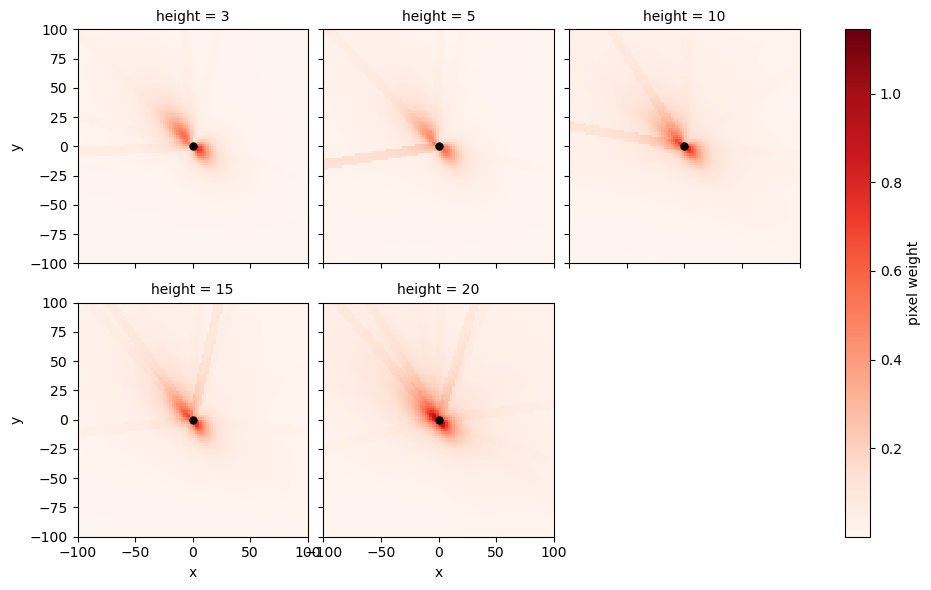

In [14]:
fig_facet = c_foots.sum(dim='time').plot(
    x='x',
    y='y',
    col='height',
    col_wrap=3,
    cmap='Reds',
    # vmax=2e-5,
    cbar_kwargs={'label': 'pixel weight'}
)
fig_facet.map(lambda: plt.plot(0, 0, marker=".", color="black", markersize=10))
plt.xlim(-100, 100)
plt.ylim(-100, 100)

In [15]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df = instrument_loc_df[instrument_loc_df.index.get_level_values(0) == 3].droplevel(0)
instrument_loc_df

,x,y,z
tower,,,
c,329002.53920,4.312171e+06,2863.30060
d,329016.82015,4.312158e+06,2862.02455
ue,329005.80410,4.312190e+06,2864.12270
uw,328983.52075,4.312165e+06,2862.50290


In [16]:
def modify_xy(foots):
    xyz = instrument_loc_df.loc[foots['tower'].item()]
    foots['x'] = foots['x'] + xyz.x
    foots['y'] = foots['y'] + xyz.y
    return foots

[c_foots_adj, uw_foots_adj, ue_foots_adj, d_foots_adj] = [
    modify_xy(foots)
    for foots in
    [c_foots, uw_foots, ue_foots, d_foots]
]

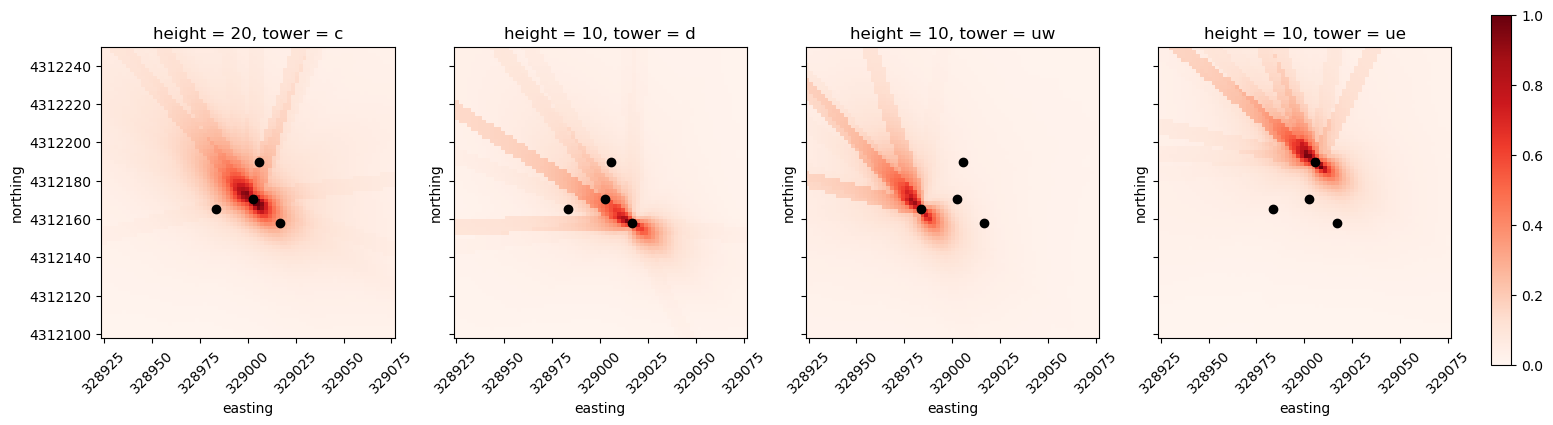

In [17]:
vmin = 0
vmax = 1.0
fig, axes = plt.subplots( 1,4, figsize=(20,5), sharex=True, sharey=True)
c_foots_adj.where(c_foots_adj).sel(height = 20).sum(dim='time').plot(   ax = axes[0], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)
d_foots_adj.where(d_foots_adj).sel(height = 10).sum(dim='time').plot(   ax = axes[1], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)
uw_foots_adj.where(uw_foots_adj).sel(height = 10).sum(dim='time').plot(  ax = axes[2], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)
im = ue_foots_adj.where(ue_foots_adj).sel(height = 10).sum(dim='time').plot(  ax = axes[3], x = 'x', y = 'y', cmap='Reds', vmin=vmin, vmax=vmax, add_colorbar=False)

for ax in axes:
    ax.set_xlim(instrument_loc_df.x.min()-60, instrument_loc_df.x.max()+60)
    ax.set_ylim(instrument_loc_df.y.min()-60, instrument_loc_df.y.max()+60)
    ax.scatter(instrument_loc_df.x, instrument_loc_df.y, color='black')
    ax.set_aspect('equal')
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='x', labelsize=10, rotation=45)
    ax.tick_params(axis='y', labelsize=10, rotation=0)
    ax.set_xlabel('easting')
    ax.set_ylabel('northing')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [18]:
xr.concat(
    [c_foots_adj,
    d_foots_adj,
    uw_foots_adj,
    ue_foots_adj],
    dim='tower'
)

: 

# Using https://github.com/Open-ET/flux-data-footprint/blob/master/scripts/calc_footprint_FFP_climatology.py

In [ ]:
    # FFP Input
    #     All vectors need to be of equal length (one value for each time step)
    #     zm       = Measurement height above displacement height (i.e. z-d) [m]
    #                usually a scalar, but can also be a vector
    #     z0       = Roughness length [m] - enter [None] if not known
    #                usually a scalar, but can also be a vector
    #     umean    = Vector of mean wind speed at zm [ms-1] - enter [None] if not known
    #                Either z0 or umean is required. If both are given,
    #                z0 is selected to calculate the footprint
    #     h        = Vector of boundary layer height [m]
    #     ol       = Vector of Obukhov length [m]
    #     sigmav   = Vector of standard deviation of lateral velocity fluctuations [ms-1]
    #     ustar    = Vector of friction velocity [ms-1]
    #     wind_dir = Vector of wind direction in degrees (of 360) for rotation of the footprint

    #     Optional input:
    #     domain       = Domain size as an array of [xmin xmax ymin ymax] [m].
    #                    Footprint will be calculated for a measurement at [0 0 zm] m
    #                    Default is smallest area including the r% footprint or [-1000 1000 -1000 1000]m,
    #                    whichever smallest (80% footprint if r not given).
    #     dx, dy       = Cell size of domain [m]
    #                    Small dx, dy results in higher spatial resolution and higher computing time
    #                    Default is dx = dy = 2 m. If only dx is given, dx=dy.
    #     nx, ny       = Two integer scalars defining the number of grid elements in x and y
    #                    Large nx/ny result in higher spatial resolution and higher computing time
    #                    Default is nx = ny = 1000. If only nx is given, nx=ny.
    #                    If both dx/dy and nx/ny are given, dx/dy is given priority if the domain is also specified.
    #     rs           = Percentage of source area for which to provide contours, must be between 10% and 90%.
    #                    Can be either a single value (e.g., "80") or a list of values (e.g., "[10, 20, 30]")
    #                    Expressed either in percentages ("80") or as fractions of 1 ("0.8").
    #                    Default is [10:10:80]. Set to "None" for no output of percentages
    #     rslayer      = Calculate footprint even if zm within roughness sublayer: set rslayer = 1
    #                    Note that this only gives a rough estimate of the footprint as the model is not
    #                    valid within the roughness sublayer. Default is 0 (i.e. no footprint for within RS).
    #                    z0 is needed for estimation of the RS.
    #     smooth_data  = Apply convolution filter to smooth footprint climatology if smooth_data=1 (default)
    #     crop         = Crop output area to size of the 80% footprint or the largest r given if crop=1
    #     pulse        = Display progress of footprint calculations every pulse-th footprint (e.g., "100")
    #     verbosity    = Level of verbosity at run time: 0 = completely silent, 1 = notify only of fatal errors,
    #                    2 = all notifications
    #     fig          = Plot an example figure of the resulting footprint (on the screen): set fig = 1.
    #                    Default is 0 (i.e. no figure).

In [62]:
from calc_footprint_FFP_climatology import ffp_climatology

locs = [
    '3m_d', '3m_ue', '3m_uw', 
    '10m_d', '10m_ue', '10m_uw', 
    '3m_c', '5m_c', '10m_c', '15m_c', '20m_c',
    
]
foots_ls = []
for loc in locs:
    [height, tower] = loc.split('m_')
    foots_ls.append(
        ffp_climatology(
            zm       = np.full(
                footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values.shape,
                int(height),
            ),
            z0       = np.full(
                footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values.shape,
                0.0001,
            ),
            umean    = footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values,
            h        = np.full(
                footprint_inputs_table.reset_index().dropna()[f'spd_{height}m_{tower}'].values.shape,
                600
            ),
            ol       = footprint_inputs_table.reset_index().dropna()[f'L_{height}m_c'].values,
            sigmav   = np.sqrt(footprint_inputs_table.reset_index().dropna()[f'v_v__{height}m_{tower}']).values,
            ustar    = footprint_inputs_table.reset_index().dropna()[f'u*_{height}m_{tower}'].values,
            wind_dir = footprint_inputs_table.reset_index().dropna()[f'dir_{height}m_{tower}'].values,
            fig=True,
        
            crop=True,
            verbosity=1

        )
    )

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()